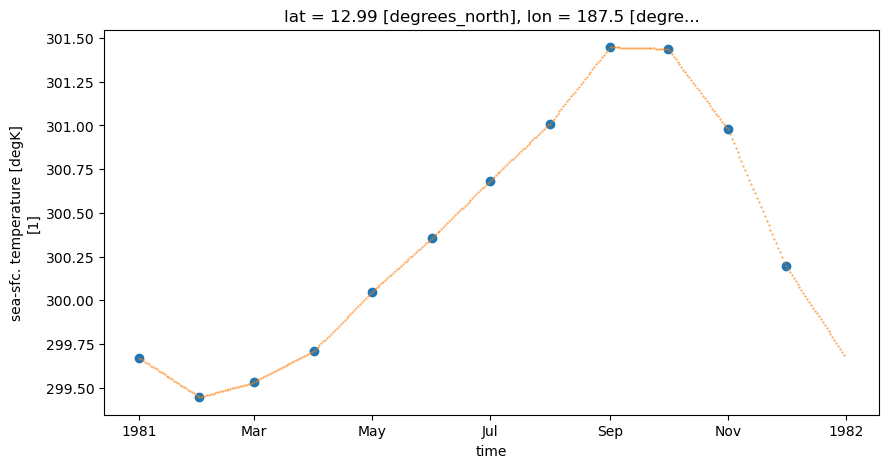

In [1]:
import xarray as xr
import pandas as pd

# get monthly data
ds_monthly = xr.open_dataset("jcm/data/bc/t30/clim/boundaries.nc")

time_vars = [var for var in ds_monthly.data_vars if 'time' in ds_monthly[var].dims]
non_time_vars = [var for var in ds_monthly.data_vars if 'time' not in ds_monthly[var].dims]

# pad monthly data with dec/jan of adjacent years
pad_n = 3 # values > 1 relevant for nonlinear interpolation
previous_year_padding = [ds_monthly[time_vars].isel(time=i) for i in range(12 - pad_n, 12)]
next_year_padding = [ds_monthly[time_vars].isel(time=i) for i in range(pad_n)]
extended_monthly_time_vars = xr.concat(previous_year_padding + [ds_monthly[time_vars]] + next_year_padding, dim='time')
extended_time = pd.date_range(start=f'1980-{13-pad_n:02}-01', end=f'1982-{pad_n:02}-01', freq='MS')
extended_monthly_time_vars['time'] = extended_time

def linear_interpolation():
    daily_time_vars = extended_monthly_time_vars.resample(time='1D').interpolate('linear')
    daily_time_vars = daily_time_vars.sel(time=slice('1981-01-01', '1981-12-31'))
    return xr.merge([daily_time_vars, ds_monthly[non_time_vars]])

def spline_interpolation():
    from scipy.interpolate import CubicSpline
    daily_time = pd.date_range(start='1981-01-01', end='1981-12-31', freq='D')
    daily_time_vars_spline = xr.Dataset()
    for var in time_vars:
        monthly_values = extended_monthly_time_vars[var].values
        monthly_time = extended_monthly_time_vars['time'].values.astype(float)
        daily_time_float = daily_time.values.astype(float)
    
        cs = CubicSpline(monthly_time, monthly_values, axis=2)
        interpolated_values = cs(daily_time_float)
    
        daily_time_vars_spline[var] = xr.DataArray(interpolated_values, coords={'time': daily_time, **{dim: extended_monthly_time_vars[var][dim] for dim in extended_monthly_time_vars[var].dims if dim != 'time'}}, dims=extended_monthly_time_vars[var].dims)
    return xr.merge([daily_time_vars_spline, ds_monthly[non_time_vars]])

ds_daily = linear_interpolation()

# check work
ds_monthly.sst.isel(lon=50, lat=20).plot(marker='o', linestyle='', size=5, aspect=2)
ds_daily.sst.isel(lon=50, lat=20).plot(marker='o', linestyle='', markersize=0.4)

In [2]:
# write to netcdf
ds_daily.to_netcdf("boundaries_daily.nc")